In [21]:
import pandas as pd
import numpy as np

# Cell: Feature Engineering and Preprocessing for ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [22]:
df = pd.read_csv("data/train_positions.csv")

df.head()

,train_id,time_start,time_end,direction,speed,longitude,latitude
0,TR001,2024-10-20 08:34:00,2024-10-20 08:39:00,W,33,-73.740641,40.714590
1,TR003,2024-10-20 09:39:00,2024-10-20 09:45:00,W,47,-73.888647,40.713272
2,TR002,2024-10-20 09:58:00,2024-10-20 10:03:00,E,31,-73.791009,40.711931
3,TR004,2024-10-20 11:47:00,2024-10-20 11:52:00,E,34,-73.847586,40.715230
4,TR005,2024-10-20 12:16:00,2024-10-20 12:23:00,W,39,-73.597366,40.712321


# Feature Engineering and Preprocessing for ML

In [23]:
# Convert time columns to datetime
df['time_start'] = pd.to_datetime(df['time_start'])
df['time_end'] = pd.to_datetime(df['time_end'])

df['day_of_week'] = df['time_start'].dt.dayofweek
# Create 10-minute time segments (0-143)
df['time_segment'] = (df['time_start'].dt.hour * 6) + (df['time_start'].dt.minute // 10)

# Optional: Create human-readable time segment (HH:MM format)
df['time_segment_readable'] = df['time_segment'].apply(
    lambda x: f"{x//6:02d}:{(x%6)*10:02d}"
)

df.head()

,train_id,time_start,time_end,direction,speed,longitude,latitude,day_of_week,time_segment,time_segment_readable
0,TR001,2024-10-20 08:34:00,2024-10-20 08:39:00,W,33,-73.740641,40.714590,6,51,08:30
1,TR003,2024-10-20 09:39:00,2024-10-20 09:45:00,W,47,-73.888647,40.713272,6,57,09:30
2,TR002,2024-10-20 09:58:00,2024-10-20 10:03:00,E,31,-73.791009,40.711931,6,59,09:50
3,TR004,2024-10-20 11:47:00,2024-10-20 11:52:00,E,34,-73.847586,40.715230,6,70,11:40
4,TR005,2024-10-20 12:16:00,2024-10-20 12:23:00,W,39,-73.597366,40.712321,6,73,12:10


In [24]:
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import prophet
from prophet import Prophet

# 1. Prepare the data for time series analysis
ts_data = df[['time_start']].copy()
ts_data.columns = ['ds']  # Prophet requires 'ds' for dates
ts_data['y'] = 1  # Each record represents a train crossing

# 2. Resample to get hourly or 10-minute counts
ts_counts = ts_data.set_index('ds').resample('10min').count()
ts_counts = ts_counts.reset_index()

# 3. Create and fit Prophet model
model = Prophet(
    changepoint_prior_scale=0.05,
    daily_seasonality=True,
    weekly_seasonality=True,
    interval_width=0.95
)
model.fit(ts_counts)

# 4. Make predictions
# Predict next 24 hours in 10-minute intervals
future_dates = model.make_future_dataframe(
    periods=144,  # 24 hours * 6 (10-minute intervals)
    freq='10min'
)
forecast = model.predict(future_dates)

13:58:06 - cmdstanpy - INFO - Chain [1] start processing
13:58:06 - cmdstanpy - INFO - Chain [1] done processing


Next 24 hours forecast:
                      ds      yhat  yhat_lower  yhat_upper
4517 2024-11-20 17:20:00  0.111964   -0.391508    0.606677
4518 2024-11-20 17:30:00  0.109432   -0.366722    0.628150
4519 2024-11-20 17:40:00  0.106554   -0.397026    0.601850
4520 2024-11-20 17:50:00  0.103353   -0.440259    0.596585
4521 2024-11-20 18:00:00  0.099854   -0.397404    0.602601
...                  ...       ...         ...         ...
4656 2024-11-21 16:30:00  0.123768   -0.384784    0.617375
4657 2024-11-21 16:40:00  0.123338   -0.354141    0.628843
4658 2024-11-21 16:50:00  0.122508   -0.365600    0.634284
4659 2024-11-21 17:00:00  0.121277   -0.376482    0.646550
4660 2024-11-21 17:10:00  0.119651   -0.367234    0.622455

[144 rows x 4 columns]


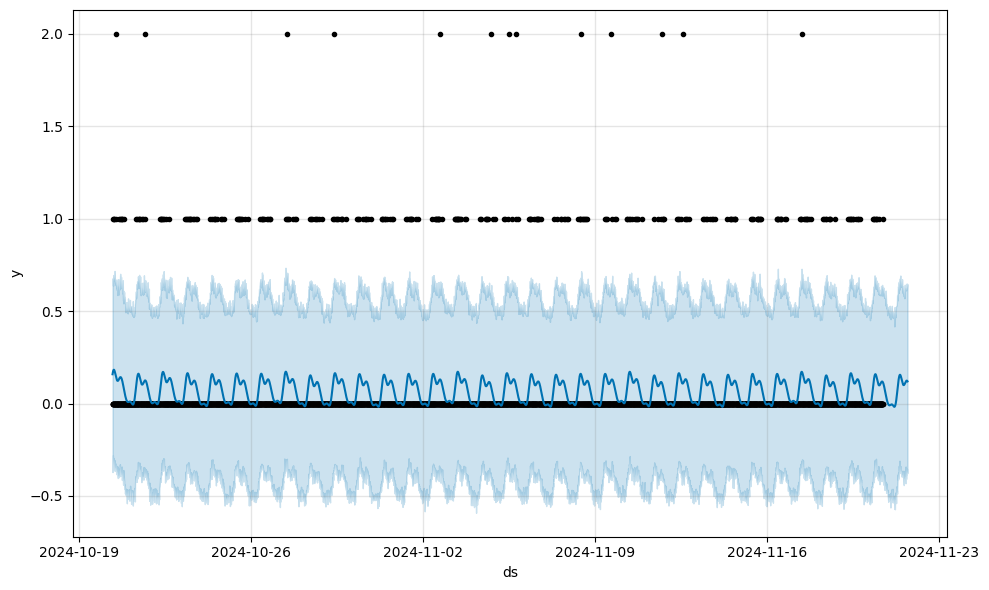

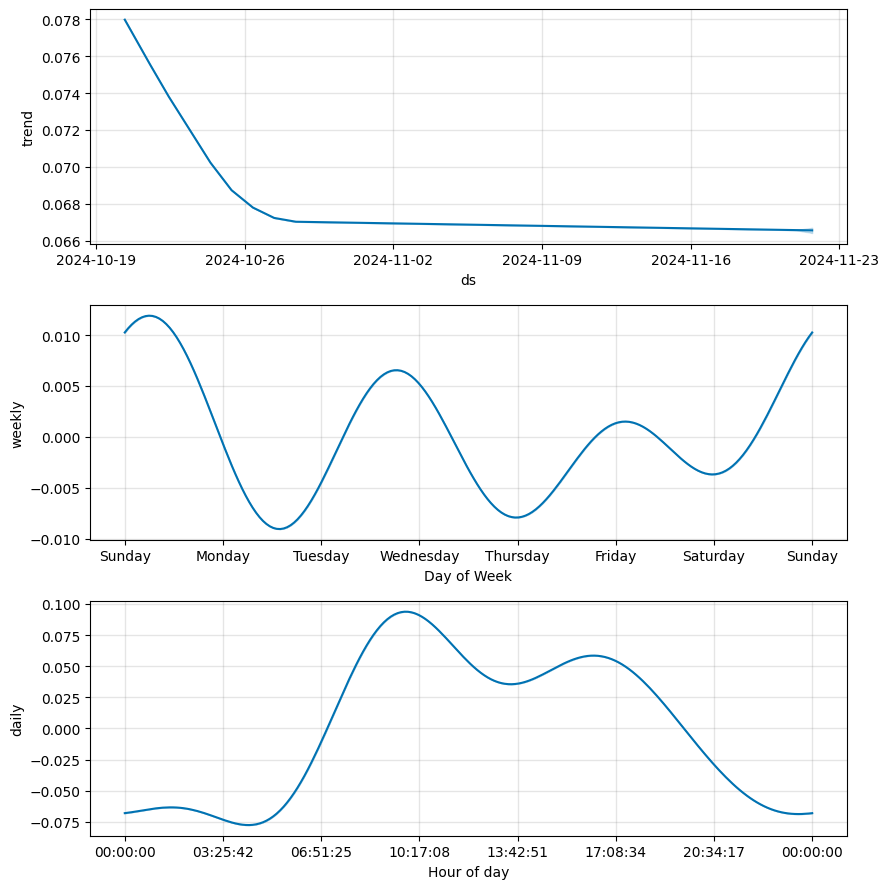

In [25]:
# 1. Basic plot showing trend and forecast
model.plot(forecast)

# 2. Show components (trend, daily seasonality, weekly seasonality)
model.plot_components(forecast)

# 3. For a more detailed view of the next 24 hours
next_day = forecast.tail(144)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
print("Next 24 hours forecast:")
print(next_day)

# 4. Create a more customized plot with plotly
import plotly.express as px

# Focus on next 24 hours
plot_data = forecast.tail(144)
fig = px.line(plot_data, 
    x='ds', 
    y=['yhat', 'yhat_lower', 'yhat_upper'],
    title='Train Crossing Forecast - Next 24 Hours',
    labels={'ds': 'Time', 'yhat': 'Predicted Crossings'},
)
fig.show()

In [26]:
from datetime import datetime, timedelta

def get_train_predictions(current_time=None):
    if current_time is None:
        current_time = datetime.now()
    
    # Get most recent train crossing
    most_recent = df[df['time_start'] <= current_time].iloc[-1]
    minutes_ago = int((current_time - most_recent['time_start']).total_seconds() / 60)
    
    # Format the "time ago" message
    if minutes_ago < 60:
        time_ago = f"{minutes_ago} minutes ago"
    else:
        hours = minutes_ago // 60
        mins = minutes_ago % 60
        time_ago = f"{hours} hours and {mins} minutes ago"
    
    # Get next hour predictions
    predictions = []
    for i in range(6):
        interval_time = current_time + timedelta(minutes=i*10)
        filtered_forecast = forecast[forecast['ds'] >= interval_time]
        
        if len(filtered_forecast) > 0:
            forecast_row = filtered_forecast.iloc[0]
            likelihood = round(forecast_row['yhat'] * 100, 1)
        else:
            likelihood = 'Unknown' # or another default value
            
        predictions.append({
            'time': interval_time.strftime('%H:%M'),
            'likelihood': likelihood
        })
    
    return {
        'last_train': {
            'time': most_recent['time_start'].strftime('%H:%M'),
            'time_ago': time_ago
        },
        'next_hour': predictions
    }

# Example usage
print("Train Crossing Information")
print("=" * 50)
info = get_train_predictions()

print(f"\nLast Train Crossing: {info['last_train']['time']} ({info['last_train']['time_ago']})")
print("\nPredicted Crossings for Next Hour:")
print("-" * 50)
time_ranges = [
        "In the next 10 minutes",
        "10-20 minutes from now",
        "20-30 minutes from now",
        "30-40 minutes from now",
        "40-50 minutes from now",
        "50-60 minutes from now"
    ]
    
for pred, time_range in zip(info['next_hour'], time_ranges):
    print(f"{time_range:25} | Likelihood: {pred['likelihood']}%")

Train Crossing Information

Last Train Crossing: 13:33 (25 minutes ago)

Predicted Crossings for Next Hour:
--------------------------------------------------
In the next 10 minutes    | Likelihood: 10.0%
10-20 minutes from now    | Likelihood: 10.1%
20-30 minutes from now    | Likelihood: 10.2%
30-40 minutes from now    | Likelihood: 10.4%
40-50 minutes from now    | Likelihood: 10.6%
50-60 minutes from now    | Likelihood: 10.8%


In [27]:
# Use last 20% of the data for testing
train_size = int(len(df) * 0.8)
train_end_date = df.iloc[train_size]['time_start']

# Prepare the data
ts_data = df[['time_start']].copy()
ts_data.columns = ['ds']
ts_data['y'] = 1
ts_data = ts_data.set_index('ds').resample('10min').count()
ts_data = ts_data.reset_index()

# Split into train and test
train_data = ts_data[ts_data['ds'] <= train_end_date]
test_data = ts_data[ts_data['ds'] > train_end_date]

# Train model
model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=False  # Remove weekly since we only have a few days
)
model.fit(train_data)

# Evaluate on test set
future = test_data[['ds']]
forecast = model.predict(future)

# Calculate final test metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
final_metrics = {
    'MAE': mean_absolute_error(test_data['y'], forecast['yhat']),
    'RMSE': np.sqrt(mean_squared_error(test_data['y'], forecast['yhat']))
}

print("\nFinal test set metrics:")
print(final_metrics)

13:58:07 - cmdstanpy - INFO - Chain [1] start processing
13:58:07 - cmdstanpy - INFO - Chain [1] done processing



Final test set metrics:
{'MAE': np.float64(0.12057444872929854), 'RMSE': np.float64(0.25062355927034663)}
